# Unintentional Equality Constraints in Contact Sets

Leading to multi-level deep null space polyhedrons

In [1]:
import numpy as np
import logging
from large_gcs.geometry.polyhedron import Polyhedron
from large_gcs.graph.incremental_contact_graph import IncrementalContactGraph
from large_gcs.graph_generators.contact_graph_generator import (
    ContactGraphGeneratorParams,
)
from large_gcs.graph.graph import Vertex


logging.basicConfig(level=logging.WARN)
logging.getLogger("large_gcs").setLevel(logging.DEBUG)

In [2]:
graph_file = ContactGraphGeneratorParams.inc_graph_file_path_from_name("cg_stackpush_a2")
cg = IncrementalContactGraph.load_from_file(
    graph_file,
    should_incl_simul_mode_switches=False,
    should_add_const_edge_cost=True,
    should_add_gcs=True,
)

contact_pair_mode_ids = ('IC|obs0_f2-obj0_f0', 'IC|obs0_f2-obj1_f0', 'IC|obs0_f2-obj2_f0', 'NC|obs0_f3-rob0_v1', 'IC|obj0_f1-obj1_f3', 'NC|obj0_f1-obj2_f3', 'IC|obj0_f3-rob0_f1', 'IC|obj1_f1-obj2_f3', 'NC|obj1_f3-rob0_f1', 'NC|obj2_f3-rob0_f1')
v_name = str(contact_pair_mode_ids)
contact_set = cg._create_contact_set_from_contact_pair_mode_ids(contact_pair_mode_ids)
vertex = Vertex(
    contact_set,
    cg._create_single_vertex_costs(contact_set),
    constraints=cg._create_single_vertex_constraints(contact_set),
)
cg.add_vertex(vertex, v_name)
chebyshev_center = contact_set.set.ChebyshevCenter()
# cg.plot_samples_in_set(v_name, np.array([chebyshev_center]))
chebyshev_center

INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 29330.80it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 13189.64it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 10 body pairs...
100%|██████████| 10/10 [00:00<00:00, 173.84it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (313)
100%|██████████| 313/313 [00:00<00:00, 4230.04it/s]


array([ 1.50000000e+00,  1.50000000e+00,  1.50000000e+00,  1.50000000e+00,
        2.50000000e+00,  2.50000000e+00,  1.50000000e+00,  1.50000000e+00,
        3.50000000e+00,  3.50000000e+00,  1.50000000e+00,  1.50000000e+00,
       -6.66667299e-09, -6.64327349e-09,  2.25000001e+00,  7.50000005e-01,
       -7.51998947e-11,  0.00000000e+00,  3.07625037e-11,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  2.33995046e-11, -1.50000000e+00,
        1.33240974e-10, -1.50000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  7.51998947e-11,  0.00000000e+00,  0.00000000e+00])

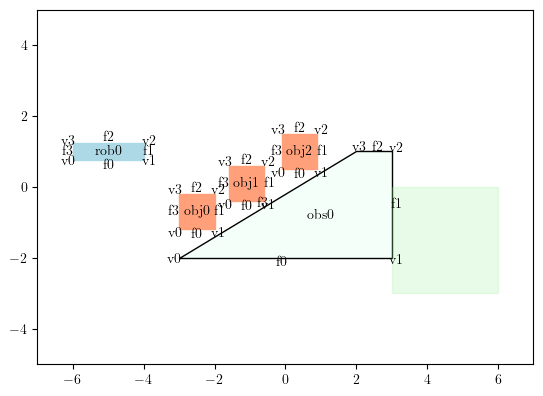

In [15]:
cg.plot()

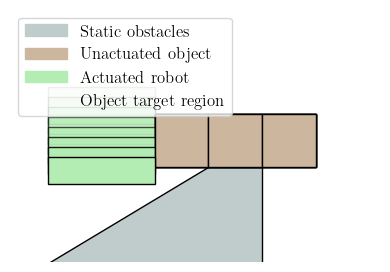

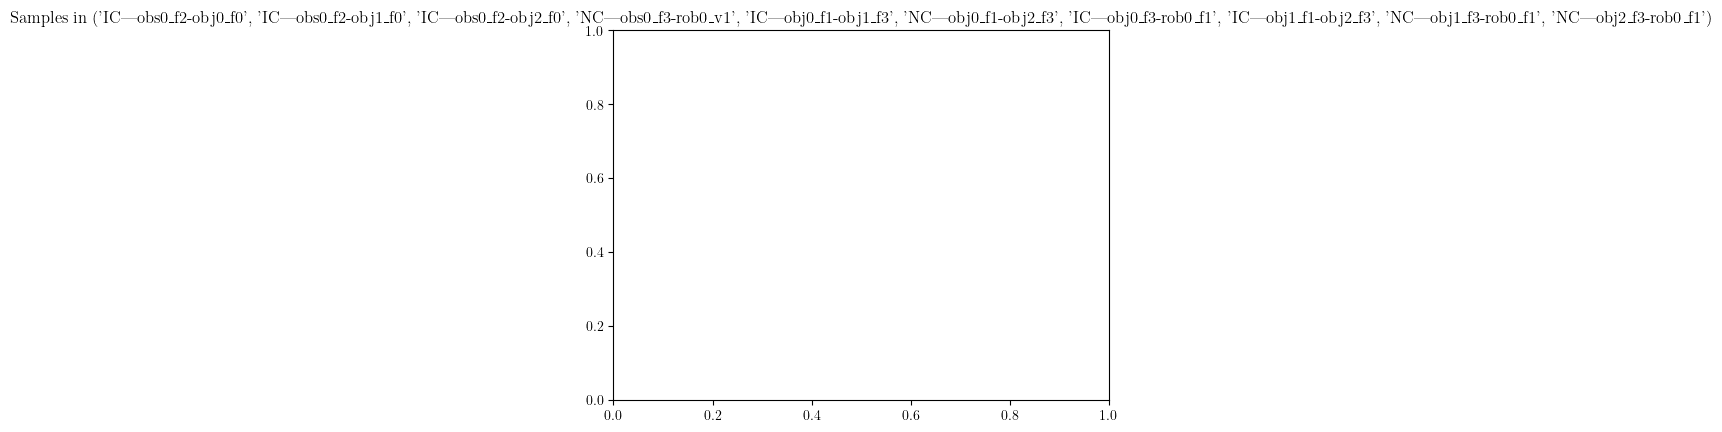

In [3]:

cg.plot_samples_in_set(v_name, np.array([chebyshev_center]))

There is only one point that satisfies these constraints, and when the tolerance is set to 0, even the Chebyshev Center is not considered to be in the set due to small numerical errors.

In [14]:
contact_set.vars.pos

array([[[Variable('obj0_pos(0, 0)', Continuous),
         Variable('obj0_pos(0, 1)', Continuous)],
        [Variable('obj0_pos(1, 0)', Continuous),
         Variable('obj0_pos(1, 1)', Continuous)]],

       [[Variable('obj1_pos(0, 0)', Continuous),
         Variable('obj1_pos(0, 1)', Continuous)],
        [Variable('obj1_pos(1, 0)', Continuous),
         Variable('obj1_pos(1, 1)', Continuous)]],

       [[Variable('obj2_pos(0, 0)', Continuous),
         Variable('obj2_pos(0, 1)', Continuous)],
        [Variable('obj2_pos(1, 0)', Continuous),
         Variable('obj2_pos(1, 1)', Continuous)]],

       [[Variable('rob0_pos(0, 0)', Continuous),
         Variable('rob0_pos(0, 1)', Continuous)],
        [Variable('rob0_pos(1, 0)', Continuous),
         Variable('rob0_pos(1, 1)', Continuous)]]], dtype=object)

In [13]:
contact_set.vars.pos_from_all(chebyshev_center)

array([[[ 1.50000000e+00,  1.50000000e+00],
        [ 1.50000000e+00,  1.50000000e+00]],

       [[ 2.50000000e+00,  2.50000000e+00],
        [ 1.50000000e+00,  1.50000000e+00]],

       [[ 3.50000000e+00,  3.50000000e+00],
        [ 1.50000000e+00,  1.50000000e+00]],

       [[-6.66667299e-09, -6.64327349e-09],
        [ 2.25000001e+00,  7.50000005e-01]]])

In this set all the bodies are in contact with the top face of the obstacle, so they can't move at all since the left and right bodies are just touching corners.
The robot is moving down from 2.25 to -0.75.

In [9]:
contact_set.set.PointInSet(chebyshev_center)

True

In [5]:
contact_set.set.IsEmpty()

False

In [6]:
# contact_set._polyhedron._has_equality_constraints

In [7]:
# contact_set._polyhedron._null_space_polyhedron._has_equality_constraints

The original set is 32 dimensional, with 190 constraints.

In [20]:
contact_set._polyhedron.set.A().shape

(190, 32)

The problem is that when we try to sample, multiple levels of null space polyhedrons get created. because after removing the intentional equality constraints, the unintentional ones begin to show up. And for some reason the lowest level one is empty (when it shouldn't be) there should be 2 dimensions that can move, the first knot point of the y position of the robot and the second knot point of the y position of the robot.

The relevant files are:
large_gcs/geometry/polyhedron.py
large_gcs/contact/contact_set.py
large_gcs/geometry/convex_set.py

In [8]:
contact_set.get_samples(10)

DEBUG:large_gcs.geometry.polyhedron:Equality constraints found: 0, 1
DEBUG:large_gcs.geometry.polyhedron:a1: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.], b1: 1.5000000012304302
DEBUG:large_gcs.geometry.polyhedron:a2: [ 0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.], b2: -1.5000000012304302
DEBUG:large_gcs.geometry.polyhedron:Polyhedron has equality constraints, creating null space polyhedron
DEBUG:large_gcs.geometry.polyhedron:
 A.shape: (134, 32), b.shape: (134,), C.shape: (28, 32), d.shape: (28,)
DEBUG:large_gcs.geometry.polyhedron:ranks: A: 32, C: 28
DEBUG:large_gcs.geometry.polyhedron:Null space polyhedron is empty: False
DEBUG:large_gcs.geometry.polyhedron:Null space polyhedron is bounded: True
DEBUG:large_gcs.geometry.polyhedron:Equality constraints found: 0, 9
DEBUG:large_gcs.geometry.polyhedron:a1: [ 0.17735474 -0.06910026  0.18316781  0.24932

Set is empty:  True
Set is bounded:  True


RuntimeError: Solver Mosek failed to solve the Chebyshev center problem; it terminated with SolutionResult InfeasibleConstraints). Make sure that your polyhedron is bounded and has an interior.

The behavior I chose to implement in this situation is to just return the chebyshev center as the only sample in the event that the sampling fails due to the chebyshev center not being in the set. This seems fine to me since there will only be one feasible point anyways so it does not make sense to return multiple samples.

In [ ]:
len(contact_set.get_samples(10))

In [19]:
P = contact_set._polyhedron
E = P._null_space_polyhedron.set.MaximumVolumeInscribedEllipsoid()

RuntimeError: Solver Mosek failed to solve the maximum inscribed ellipse problem; it terminated with SolutionResult SolverSpecificError). Make sure that your polyhedron is bounded and has an interior.

In [ ]:
contact_set.vars.all.shape

In [ ]:
contact_set.dim

In [ ]:
cg.params